Neste módulo, veremos algumas considerações sobre como aplicar os conceitos vistos até agora a aplicações de processamento de linguagem natural.

Como nosso primeiro exemplo, veremos como fazer um modelo simples para aprender se uma critica de um filme é positiva ou negativa, usando uma coleção de referência do site IMDb.

## Pré-processando os dados

Até agora trabalhamos com imagens, que possuem várias vantagens: tamanho fixo, formato padronizado (3 cores), bases de dados relativamente livres de ruído.

Não podemos assumir o mesmo de bases de texto. Documentos de texto possuem diversas particularidades, como um universo muito grande de palavras possíveis, documentos com tamanhos variáveis, lixo (como erros de digitação), etc.

Por isto, antes de se trabalhar com texto, se deve fazer alguns passos para tornar o mesmo mais _limpo_.


In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
import sklearn.metrics
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

E:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
output_dir = 'model_output/imdb_deep_net'
epochs = 4
batch_size = 128
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50
max_review_length = 100
pad_type = trunc_type = 'pre' #Outra opcao eh post
n_dense = 64
dropout = 0.5

(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

Para o nosso treinamento, iremos usar os hiperparâmetros acima. Alguns vocês já conhecem, mas temos alguns específicos de texto:

- n_unique_words: o tamanho do vocabulário a ser considerado
- n_words_to_skio: As n palavras mais frequentes serão ignoradas (stopwords)
- max_review_length: Por enquanto, trabalharemos com documentos de tamanho fixo (100 palavras)


Vamos dar uma olhada em como estão os documentos por enquanto:

In [ ]:
for x in X_train[0:6]:
    print(len(x))    

print(X_train[5])

for y in y_train[0:6]:
    print(y)

### Visualizando documentos ###

Estranho né? Antes de tudo, seria bom descobrir que documento é esse, e transformar esses IDs em palavras:

In [3]:
word_index = keras.datasets.imdb.get_word_index()
# Vamos empurrar esse dicionario 3 posicoes
word_index = {k : (v+3) for k,v in word_index.items()}
# Vamos adicionar essas tres entradas padrao nos indices corretos
word_index['PAD'] = 0 #Padding para documentos com menos de 100 palavras
word_index['START'] = 1 #Inicio do documento
word_index['UNK'] = 2 #Termo "desconhecido"
index_word = {v:k for k,v in word_index.items()}

In [4]:
review = ' '.join(index_word[id] for id in X_train[4])
print(review)

UNK worst mistake UNK my life UNK UNK UNK picked UNK UNK up UNK target UNK 5 because UNK figured hey UNK sandler UNK can get UNK cheap laughs UNK UNK wrong completely wrong mid way through UNK UNK UNK three UNK my friends were asleep UNK UNK UNK still suffering worst plot worst script worst UNK UNK UNK ever seen UNK wanted UNK hit my head up against UNK wall UNK UNK hour then i'd stop UNK UNK know why because UNK felt damn good upon UNK my head UNK UNK stuck UNK damn UNK UNK UNK UNK UNK watched UNK burn UNK UNK felt better than anything else i've ever done UNK took american psycho army UNK darkness UNK kill bill UNK UNK get over UNK crap UNK hate UNK sandler UNK actually going through UNK UNK UNK UNK UNK whole day UNK my life


Vamos comparar com o conteúdo original:

In [5]:
(all_X_train, _), (all_X_valid, _) = imdb.load_data()
full_review = ' '.join(index_word[id] for id in all_X_train[5])
print(full_review)

START begins better than it ends funny that the russian submarine crew outperforms all other actors it's like those scenes where documentary shots br br spoiler part the message dechifered was contrary to the whole story it just does not mesh br br


Os documentos continuam com tamanhos variáveis. Vamos agora normalizá-los para um tamanho padrão, truncando ou fazendo padding conforme necessário:

In [6]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [14]:
for x in X_train[0:6]:
    print(len(x))

100
100
100
100
100
100


In [16]:
review = ' '.join(index_word[id] for id in X_train[4])
print(review)

UNK UNK still suffering worst plot worst script worst UNK UNK UNK ever seen UNK wanted UNK hit my head up against UNK wall UNK UNK hour then i'd stop UNK UNK know why because UNK felt damn good upon UNK my head UNK UNK stuck UNK damn UNK UNK UNK UNK UNK watched UNK burn UNK UNK felt better than anything else i've ever done UNK took american psycho army UNK darkness UNK kill bill UNK UNK get over UNK crap UNK hate UNK sandler UNK actually going through UNK UNK UNK UNK UNK whole day UNK my life


Como vocês podem ver, o padding (e a truncagem quando necessário) são feitos no início. Você pode alterar isto alterando os parâmetros `pad_type` e `trunc_type`.

## Treinando um classificador para análise de sentimentos ##

Vamos agora fazer uma FNN simples para aprender a classificar as críticas como positivas ou negativas:

In [7]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, 
                    input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


Temos aqui um novo tipo de camada, a camada de embedding. Esta é uma camada que recebe como entrada um vetor de id de palavras com tamanho igual a `max_review_length` e contendo até no máximo `n_unique_words` ids diferentes, e transforma cada uma dessas palavras em um vetor com `n_dim` dimensões.

Desta forma, esta camada está criando uma representação vetorial do que é uma palavra, e representa cada documento como cem vetores de palavras.

Em uma aula futura, entenderemos melhor como são criados e como funcionam estes embeddings, mas por enquanto o importante é entender que eles são uma forma de representar palavras que faz mais sentido para as redes neurais.

In [8]:
tboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names='embedding_1', embeddings_metadata=None, embeddings_data=None)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, callbacks=[tboard])

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 1s 66us/step - loss: 0.6092 - acc: 0.6433 - val_loss: 0.3848 - val_acc: 0.8334
Epoch 2/4
20000/20000 [==============================] - 1s 42us/step - loss: 0.3076 - acc: 0.8750 - val_loss: 0.3577 - val_acc: 0.8408
Epoch 3/4
20000/20000 [==============================] - 1s 42us/step - loss: 0.1443 - acc: 0.9553 - val_loss: 0.3931 - val_acc: 0.8420
Epoch 4/4
20000/20000 [==============================] - 1s 42us/step - loss: 0.0349 - acc: 0.9938 - val_loss: 0.4829 - val_acc: 0.8352


Por enquanto não usamos o conjunto de validação que veio com a base de dados, mas sim 20% do treino. Fizemos isto pois vamos utilizar o conjunto de validacao como teste:

In [9]:
y_hat = model.predict_proba(X_valid)

pct_auc = roc_auc_score(y_valid, y_hat) * 100
print('{:0.2f}'.format(pct_auc))

91.55


Estou mostrando a curva ROC AUC (média sob o recebedor). Ela leva tanto em consideração a taxa verdadeiros positivos quanto a taxa de falso positivos:

$$
T_{V+} = \frac{V_{+}}{ (V_{+} + F_{-})} \\
T_{F+} = \frac{F_{+}} {(F_{+} + V_{-})}
$$

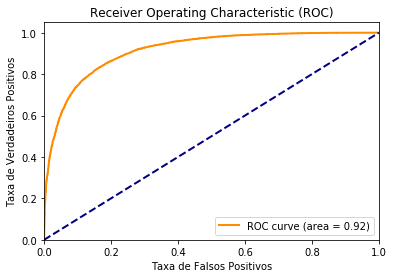

In [10]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_valid, y_hat)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Create a Pandas DataFrame to hold y_hat and y values.
ydf = pd.DataFrame(list(zip(y_hat[:,0], y_valid)),
                   columns=['previsto', 'real'])
# Print the first 10 rows.
print(ydf.head(10))

   previsto  real
0  0.126988     0
1  0.999717     1
2  0.974634     1
3  0.365254     0
4  0.999940     1
5  0.952179     1
6  0.978445     1
7  0.002977     0
8  0.384830     0
9  0.910281     1


In [14]:
# Read a full review. In that case, the 1st one.
index = 0
review = ' '.join(index_word[id] for id in all_X_valid[1])
print(review)

START this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances austen's the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere rife with sexual tension and psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the solemn moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual repression and desperation be patient s

Esta é baseado no material de <a href="" >Wilder Rodrigues